In [42]:
import os
import shap

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import BaseCrossValidator, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from catboost import CatBoostClassifier, Pool, cv, EShapCalcType, EFeaturesSelectionAlgorithm
from collections import Counter

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

In [43]:
# pd.set_option('display.max_rows',None)
# pd.set_option('display.max_columns',None)
# pd.set_option('display.max_colwidth',None)

## Вспомогательные функции

In [44]:
def plot_pr_curve(test_y, predictions):
    precision, recall, _ = precision_recall_curve(test_y, predictions)
    plt.plot(recall, precision, marker='.', label='catboost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def plot_roc_curve(test_y, predictions):
    fpr, tpr, _ = roc_curve(test_y, predictions)
    plt.plot(fpr, tpr, marker='.', label='catboost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_fit_curves(model):
    plt.plot(
        range(0, len(model.evals_result_['learn']['AUC'])),
        model.evals_result_['learn']['AUC'],
        label='learn'
    )
    plt.plot(
        range(0, len(model.evals_result_['learn']['AUC'])),
        model.evals_result_['validation']['AUC'],
        label='val'
    )
    plt.legend()
    plt.show()

def plot_target_segment(test_y, predictions):
    hist_df = pd.DataFrame(
        {
            'target':test_y.values,
            'proba':predictions
        }
    )
    hist_df = hist_df.sort_values(by='proba', ascending=False)
    
    num_segments = 20
    segment_length = len(hist_df) // num_segments
    array_21 = [21]*(len(hist_df)-num_segments*segment_length)
    hist_df['segment'] = list(np.repeat(range(1, num_segments + 1), segment_length)) + array_21
    
    hist_df = hist_df.groupby('segment')['target'].sum()
    plt.bar(list(hist_df.index), list(hist_df.values))
    plt.show()

def plot_shap(model, df):
    zero_df = df.loc[df['target']==0].drop(['target','report_date'],axis=1).sample(100)
    one_df = df.loc[df['target']==1].drop(['target','report_date'],axis=1)
    shap_values = (
        shap.TreeExplainer(model)
        .shap_values(zero_df)
    )
    shap.summary_plot(
        shap_values, 
        zero_df
    )
    shap_values = (
        shap.TreeExplainer(model)
        .shap_values(one_df)
    )
    shap.summary_plot(
        shap_values, 
        one_df
    )

def fit_catboost(pool_train, pool_val):
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        eval_metric='AUC:hints=skip_train~false',
        random_seed=1
    )
    
    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=False
    )
    return model

def fit_catboost_select(pool_train, pool_val):
    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        random_seed=1
    )
    
    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=False
    )
    return model

## Коннект к mlflow

In [45]:
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://161.35.150.68:9000'
os.environ["AWS_ACCESS_KEY_ID"] = "6owG9ybVXncQyUFCu7eTEn_mteDf12aAKUgkqLJj76e2V5Yz7NxlVSJnly5dfPH-InWnHdBru062ABgJRU2Z0A"
os.environ["AWS_SECRET_ACCESS_KEY"] = "Gh85cb1UQ2vWO1AvRl9Dld94gKluLnBnvC-tCfSntBikx_A_dD4G842d7RejjDR6BTH0Ko2qaWidswbjm_at4Q"
os.environ["MLFLOW_TRACKING_URI"] = "http://161.35.150.68:5000"

mlflow.set_experiment(experiment_name=f'denis_test')
client = MlflowClient()

## Датасет

In [46]:
fa = pd.read_parquet('data/factor_analysis.parquet')

cat_cols = [
    'col520', 'col552', 'col543', 'col527', 'col607', 'col600', 'col599',
    'col560', 'col548', 'col551', 'col535', 'col540', 'col464', 'col152',
    'col228', 'col559', 'col460', 'col472', 'col568', 'col468'
]
features = (
    list(fa
    .loc[
        (fa['not_null_percent']>0.05)
        & (fa['mode_frequency']<0.8)
        & (fa['ind_gini']>0.001),
        'feature_name'
    ].unique())
)
features = ['report_date', 'client_id', 'target'] + cat_cols + list(features)
print(len(features))
df = pd.read_parquet(
    'data/data_v1',
    columns=features
)

last_3m = sorted(df['report_date'].unique())[-3:]

train_df = (
    df[~df['report_date'].isin(last_3m)].reset_index().drop(columns = ['index'])
    .drop(['client_id'], axis=1)
)

test_df = (
    df[df['report_date'].isin(last_3m)].reset_index().drop(columns = ['index'])
    .drop(['report_date', 'client_id'], axis=1)
)

902


## Модель

### Обычная тренировка

0.14067700114137374
0.8521455083134675


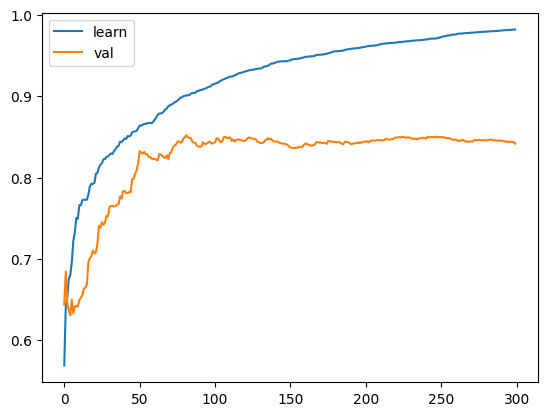

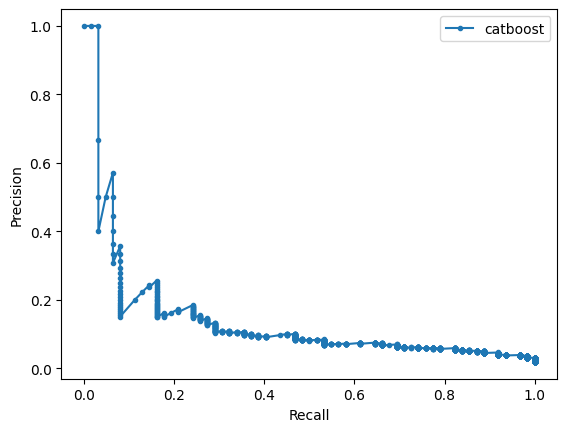

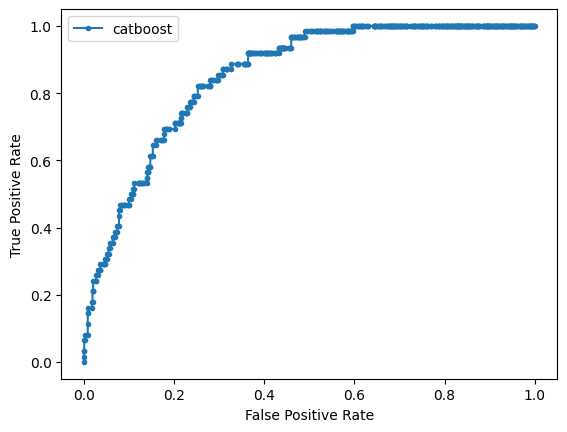

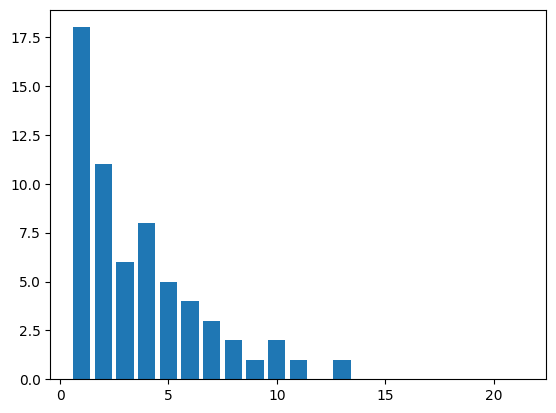

D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



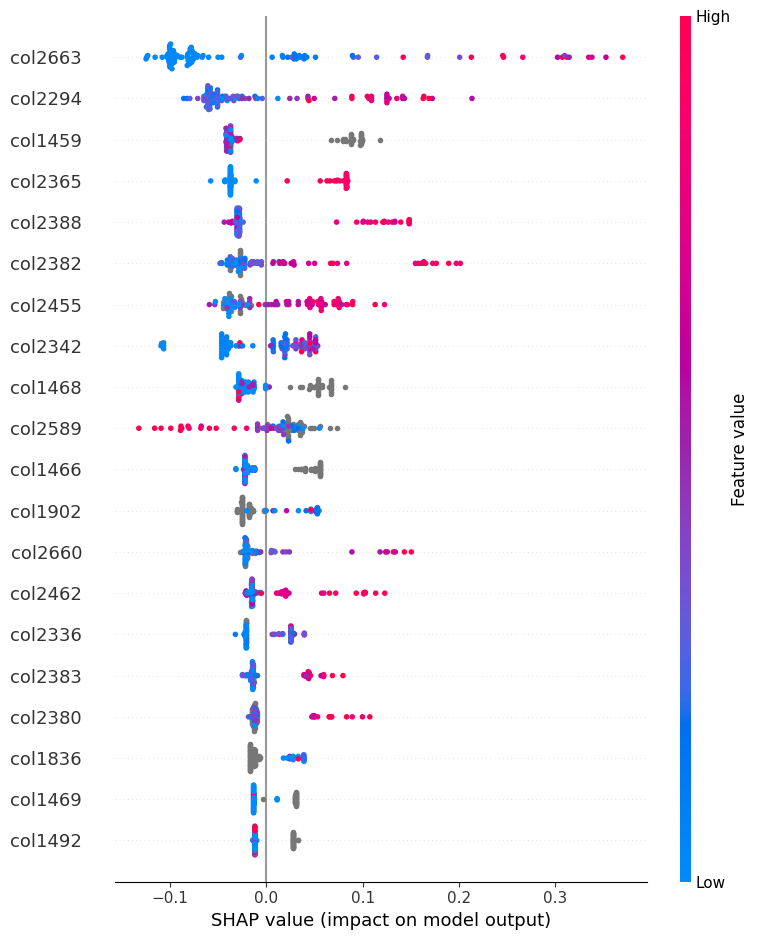

D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



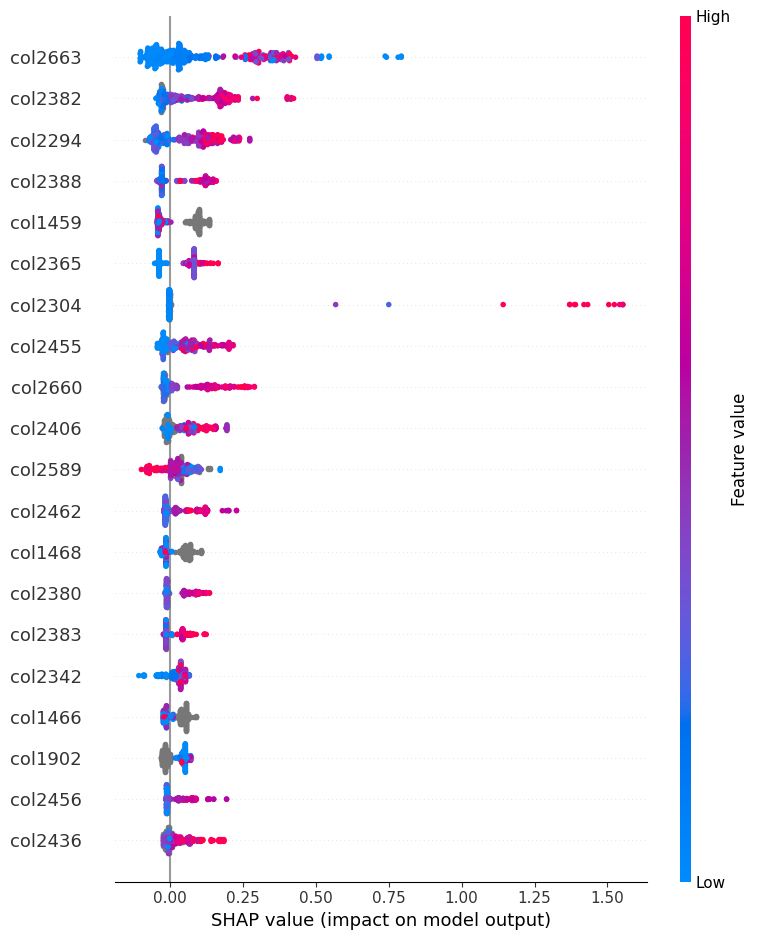

In [96]:
#train_df = train_df.loc[train_df['report_date'].isin(['2022-11-01', '2022-10-01'])]

pool_train = Pool(
    train_df.drop(['target', 'report_date'], axis=1),
    train_df['target'],
    cat_features = list(
        train_df.drop(['target','report_date'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

pool_val = Pool(
    test_df.drop('target', axis=1),
    test_df['target'],
    cat_features = list(
        train_df.drop('target', axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

model = fit_catboost(pool_train,pool_val)

predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
print(auc(recall, precision))
print(roc_auc_score(test_df['target'], predictions))

plot_fit_curves(model)
plot_pr_curve(test_df['target'], predictions)
plot_roc_curve(test_df['target'], predictions)
plot_target_segment(test_df['target'], predictions)
plot_shap(model, train_df)

## Отбор фичей с помощью shap catboost на кастромном btscv

In [47]:
class BlockedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits, train_size, test_size, col_date):
        self.test_size = test_size
        # n_splits с учетом дат, которые нужно сохранить для тестовой выборки
        self.n_splits = n_splits+test_size-1
        # вычисляем, сколько последних дат требуется оставить для кроссвалидации с такими параматрами
        self.n_dates = self.n_splits-1+test_size+train_size
        self.ts = TimeSeriesSplit(n_splits=self.n_splits, test_size=1, max_train_size=train_size)
        self.col_date = col_date
        
        
    def get_n_splits(self, X):
        return self.n_splits

    def split(self,X, y=None, groups = None):
        X = self.col_date
        X = np.array(X)
        # Уникальные элементы списка
        X_uniq = np.unique(X)[-self.n_dates:]

        for train_index, test_index in self.ts.split(X_uniq):
            try:
                test_index = np.arange(test_index[0], test_index[0]+self.test_size)
                train_dates = X_uniq[train_index]
                test_dates = X_uniq[test_index]
                train_index = np.where(np.isin(X, train_dates))
                test_index = np.where(np.isin(X, test_dates))
                
                yield train_index[0], test_index[0]    
            except:
                break

                
def btscv_feature_selection(data, n_splits, train_size, test_size):
    all_bad_features = []
    all_good_features = []
    
    # n_splits - сколько сплитов в кроссвалидации
    # train_size - количество уникальных дат в тренировочной выборке
    # test_size - количество уникальных дат в тестовой выборке
    btscv = BlockedTimeSeriesSplit(
        n_splits=n_splits,
        train_size=train_size,
        test_size=test_size,
        col_date = data['report_date']
    )
    
    for train_index, test_index in tqdm(btscv.split(data)):
        print('train')
        display(data.iloc[train_index]['report_date'].unique())
        print('test')
        display(data.iloc[test_index]['report_date'].unique())
        print('-'*100)
        
        # Создаём датасет
        len_ones = data.iloc[train_index].loc[data['target']==1].shape[0]
        zeros = data.iloc[train_index].loc[data['target']==0].sample(n=len_ones*6, random_state=0)
        ones = data.iloc[train_index].loc[data['target']==1]
        ones = pd.concat([zeros,ones])
        
        X_train = ones.drop(columns = ['target', 'report_date'])
        y_train = ones['target']
        
        X_test = data.iloc[test_index].drop(columns = ['target', 'report_date'])
        y_test = data.iloc[test_index]['target']
        
        X_train[X_train.select_dtypes('object').columns] = X_train[X_train.select_dtypes('object').columns].astype(str)
        X_test[X_test.select_dtypes('object').columns] = X_test[X_test.select_dtypes('object').columns].astype(str)
        pool_train = Pool(
            X_train,
            label=y_train,
            cat_features = list(X_train.select_dtypes('object').columns)
        )
        
        pool_val = Pool(
            X_test,
            label=y_test,
            cat_features = list(X_test.select_dtypes('object').columns)
        )
        
        model = fit_catboost_select(pool_train,pool_val)
        
        feature_selection = model.select_features(
            pool_train,
            eval_set=pool_val,
            features_for_select=list(X_train.drop('col2663', axis=1).columns),
            num_features_to_select=650,
            steps=1,
            algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=False,
            plot=True,
            verbose=0
        )
        bad_features = (
            feature_selection['eliminated_features_names']
            [
                :feature_selection['loss_graph']['loss_values']
                .index(min(feature_selection['loss_graph']['loss_values']))
            ]
        )
        all_bad_features += bad_features
    counter = Counter(all_bad_features)
    all_bad_features = [f for f, count in counter.items() if count > 1]
    print(all_bad_features)
    good_features = [f for f in X_train.columns if f not in all_bad_features]
    
    return good_features

0it [00:00, ?it/s]

train


['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01']
Categories (25, object): ['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', ..., '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01']

test


['2022-07-01', '2022-08-01', '2022-09-01']
Categories (25, object): ['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', ..., '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01']

----------------------------------------------------------------------------------------------------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 1

bestTest = 0.1294325222
bestIteration = 298

Shrink model to first 299 iterations.
Feature #197 eliminated
Feature #342 eliminated
Feature #108 eliminated
Feature #182 eliminated
Feature #805 eliminated
Feature #209 eliminated
Feature #326 eliminated
Feature #557 eliminated
Feature #111 eliminated
Feature #244 eliminated
Feature #28 eliminated
Feature #693 eliminated
Feature #225 eliminated
Feature #18 eliminated
Feature #88 eliminated
Feature #104 eliminated
Feature #31 eliminated
Feature #37 eliminated
Feature #60 eliminated
Feature #479 eliminated
Feature #855 eliminated
Feature #14 eliminated
Feature #258 eliminated
Feature #12 eliminated
Feature #21 eliminated
Feature #845 eliminated
Feature #53 eliminated
Feature #778 eliminated
Feature #699 eliminated
Feature #122 eliminated
Feature #400 eliminated
Feature #648 eliminated
Feature #371 eliminated
Feature #487 eliminated
Feature #764 eliminated
Feature #11 eliminated
Feature #580 eliminated
Feature #432 eliminate

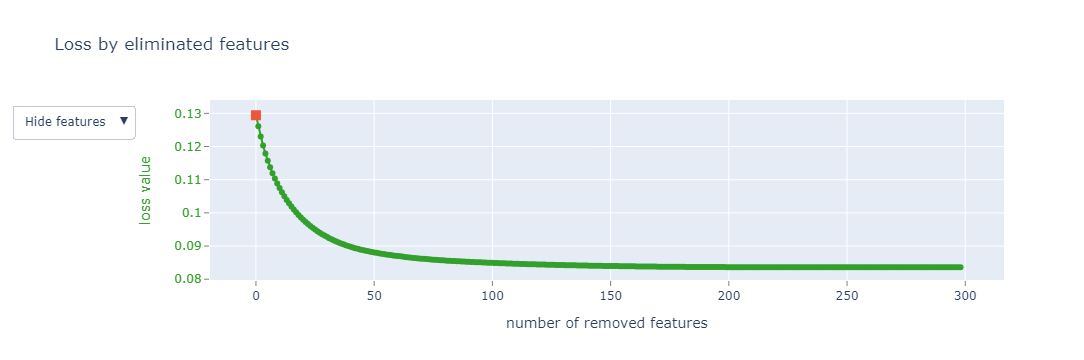

1it [10:25, 625.39s/it]

train


['2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01']
Categories (25, object): ['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', ..., '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01']

test


['2022-08-01', '2022-09-01', '2022-10-01']
Categories (25, object): ['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', ..., '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01']

----------------------------------------------------------------------------------------------------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 1

bestTest = 0.1424963995
bestIteration = 296

Shrink model to first 297 iterations.
Feature #18 eliminated
Feature #523 eliminated
Feature #5 eliminated
Feature #429 eliminated
Feature #745 eliminated
Feature #691 eliminated
Feature #477 eliminated
Feature #229 eliminated
Feature #883 eliminated
Feature #296 eliminated
Feature #37 eliminated
Feature #223 eliminated
Feature #108 eliminated
Feature #122 eliminated
Feature #733 eliminated
Feature #254 eliminated
Feature #780 eliminated
Feature #112 eliminated
Feature #144 eliminated
Feature #201 eliminated
Feature #173 eliminated
Feature #309 eliminated
Feature #60 eliminated
Feature #816 eliminated
Feature #344 eliminated
Feature #639 eliminated
Feature #423 eliminated
Feature #720 eliminated
Feature #285 eliminated
Feature #681 eliminated
Feature #576 eliminated
Feature #365 eliminated
Feature #648 eliminated
Feature #704 eliminated
Feature #388 eliminated
Feature #91 eliminated
Feature #489 eliminated
Feature #243 elim

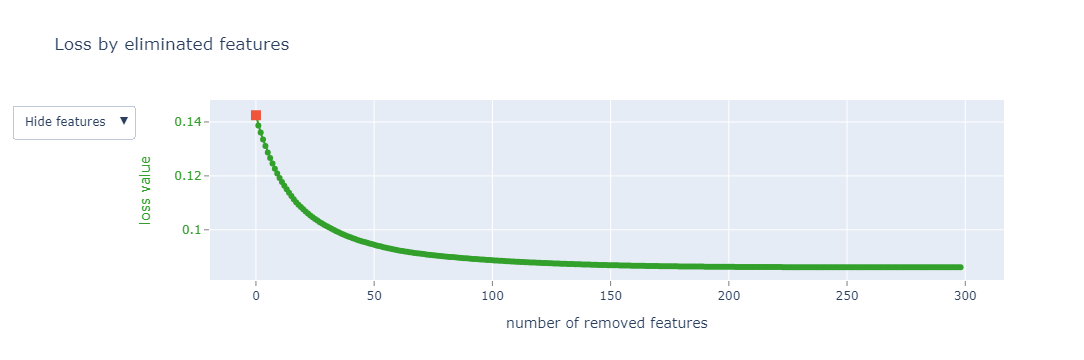

2it [21:04, 633.43s/it]

train


['2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01']
Categories (25, object): ['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', ..., '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01']

test


['2022-09-01', '2022-10-01', '2022-11-01']
Categories (25, object): ['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', ..., '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01']

----------------------------------------------------------------------------------------------------


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 1

bestTest = 0.1259976997
bestIteration = 274

Shrink model to first 275 iterations.
Feature #335 eliminated
Feature #28 eliminated
Feature #117 eliminated
Feature #135 eliminated
Feature #16 eliminated
Feature #570 eliminated
Feature #122 eliminated
Feature #272 eliminated
Feature #883 eliminated
Feature #388 eliminated
Feature #12 eliminated
Feature #55 eliminated
Feature #565 eliminated
Feature #365 eliminated
Feature #429 eliminated
Feature #745 eliminated
Feature #708 eliminated
Feature #710 eliminated
Feature #523 eliminated
Feature #98 eliminated
Feature #52 eliminated
Feature #138 eliminated
Feature #245 eliminated
Feature #108 eliminated
Feature #58 eliminated
Feature #595 eliminated
Feature #107 eliminated
Feature #229 eliminated
Feature #489 eliminated
Feature #87 eliminated
Feature #306 eliminated
Feature #816 eliminated
Feature #583 eliminated
Feature #22 eliminated
Feature #637 eliminated
Feature #726 eliminated
Feature #581 eliminated
Feature #477 elimina

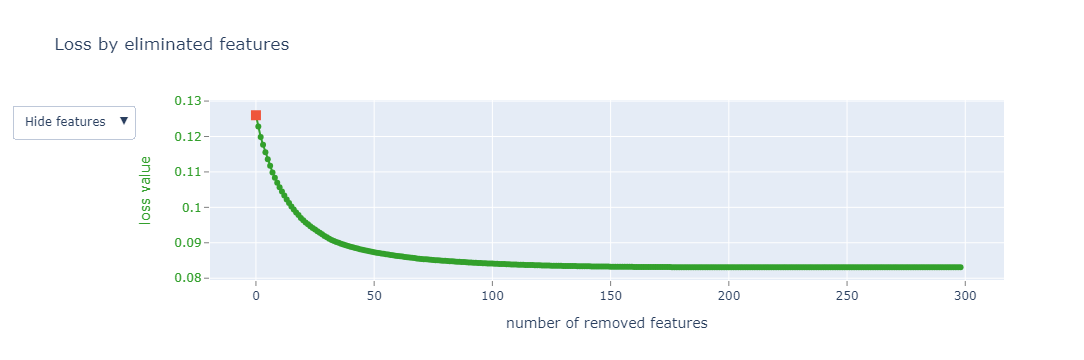

3it [31:15, 625.19s/it]

['col1856', 'col2325', 'col1861', 'col2456', 'col480', 'col2211', 'col568', 'col1824', 'col2087', 'col464', 'col507', 'col2468', 'col2307', 'col2438', 'col2326', 'col1828', 'col723', 'col540', 'col2222', 'col1970', 'col2032', 'col492', 'col1858', 'col2336', 'col2283', 'col503', 'col2182', 'col2205', 'col1826', 'col2028', 'col2560', 'col2221', 'col2085', 'col700', 'col2430', 'col1987', 'col1897', 'col2131', 'col2650', 'col491', 'col2281', 'col476', 'col2398', 'col2371', 'col2304', 'col2141', 'col2332', 'col2282', 'col2656', 'col2359', 'col1466', 'col767', 'col2431', 'col2276', 'col2557', 'col2347', 'col2179', 'col2652', 'col2142', 'col1467', 'col2406', 'col2275', 'col2395', 'col2630', 'col2426', 'col2084', 'col2440', 'col2278', 'col1957', 'col367', 'col2280', 'col2408', 'col488', 'col688', 'col2217', 'col1974', 'col2289', 'col2378', 'col320', 'col2286', 'col607', 'col474', 'col1465', 'col535', 'col2170', 'col1860', 'col2230', 'col712', 'col2187', 'col2148', 'col2403', 'col2648', 'col264

In [48]:
good_features = btscv_feature_selection(train_df, n_splits=3, train_size=5, test_size=3)

In [49]:
print(len(good_features))
np.save('good_features.npy', np.array(list(good_features)))

748


### Отбор фичей с помощью shap catboost на одной валидации

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 2

bestTest = 0.1094640485
bestIteration = 298

Shrink model to first 299 iterations.
Feature #446 eliminated
Feature #883 eliminated
Feature #265 eliminated
Feature #229 eliminated
Feature #521 eliminated
Feature #291 eliminated
Feature #243 eliminated
Feature #101 eliminated
Feature #335 eliminated
Feature #523 eliminated
Feature #108 eliminated
Feature #105 eliminated
Feature #379 eliminated
Feature #342 eliminated
Feature #726 eliminated
Feature #492 eliminated
Feature #678 eliminated
Feature #582 eliminated
Feature #86 eliminated
Feature #738 eliminated
Feature #554 eliminated
Feature #47 eliminated
Feature #122 eliminated
Feature #155 eliminated
Feature #37 eliminated
Feature #700 eliminated
Feature #745 eliminated
Feature #29 eliminated
Feature #501 eliminated
Feature #349 eliminated
Feature #424 eliminated
Feature #637 eliminated
Feature #819 eliminated
Feature #710 eliminated
Feature #18 eliminated
Feature #279 eliminated
Feature #255 eliminated
Feature #23 elim

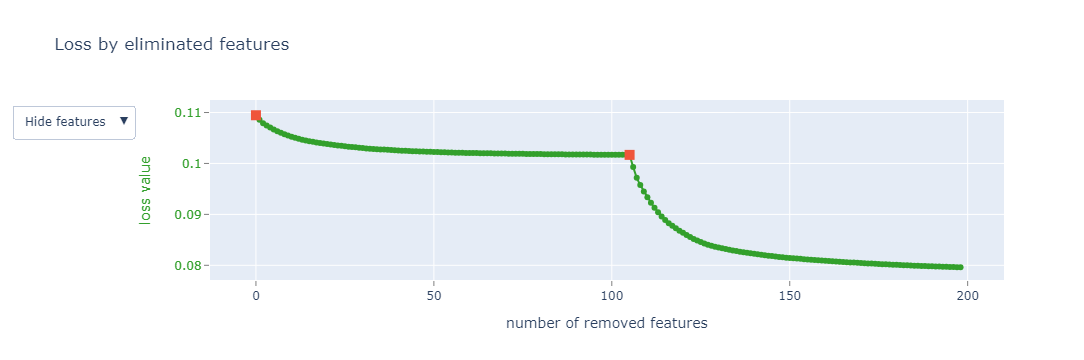

False


In [86]:
_train_df = train_df.loc[train_df['report_date'].isin(['2022-08-01', '2022-07-01', '2022-06-01', '2022-05-01', '2022-04-01'])]
ones = _train_df.loc[_train_df['target']==1]
zeros = _train_df.loc[_train_df['target']==0].sample(ones.shape[0]*6,random_state=0)
_train_df = pd.concat([ones,zeros])

_test_df = train_df.loc[train_df['report_date'].isin(['2022-09-01', '2022-10-01', '2022-11-01'])]

pool_train = Pool(
    _train_df.drop(['report_date', 'target'], axis=1),
    label=_train_df['target'],
    cat_features = list(
        _train_df
        .drop(['report_date', 'target'], axis=1)
        .select_dtypes('object').columns
    )
)

pool_val = Pool(
    _test_df.drop(['report_date', 'target'], axis=1),
    label=_test_df['target'],
    cat_features = list(
        _train_df
        .drop(['report_date', 'target'], axis=1)
        .select_dtypes('object').columns
    )
)

model = fit_catboost_select(pool_train,pool_val)

feature_selection = model.select_features(
    pool_train,
    eval_set=pool_val,
    features_for_select=list(_train_df.drop(['report_date', 'target', 'col2663'],axis=1).columns),
    num_features_to_select=700,
    steps=2,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    plot=True,
    verbose=0
)

good_features = feature_selection['selected_features_names']
print('col2663' in (good_features)) 

In [50]:
good_features = list(np.load('good_features.npy', allow_pickle=True))
print(len(good_features))

748


### Тест на всех фичах

0.2231696737990704
0.9119290463401633


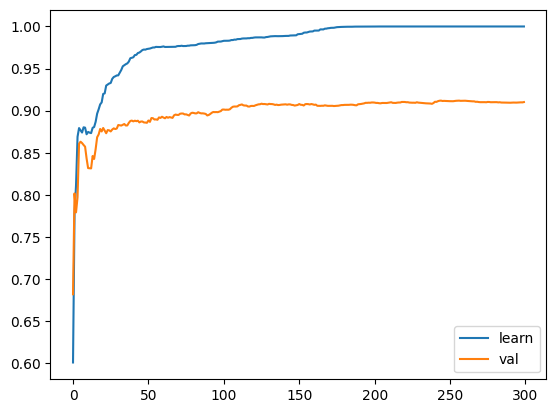

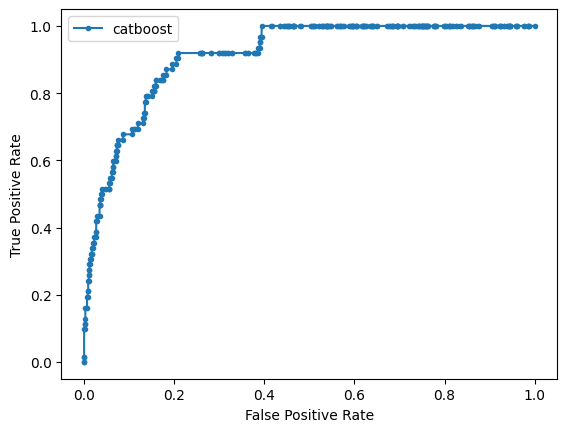

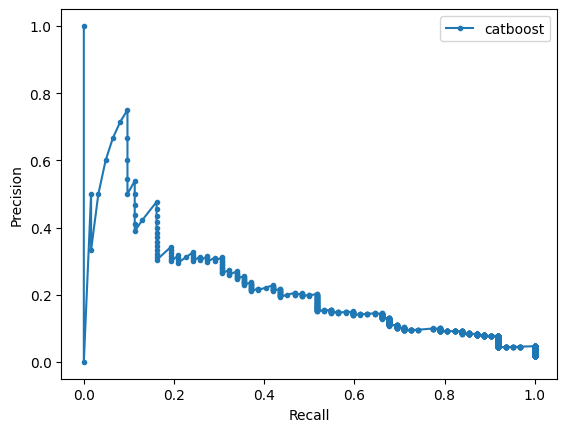

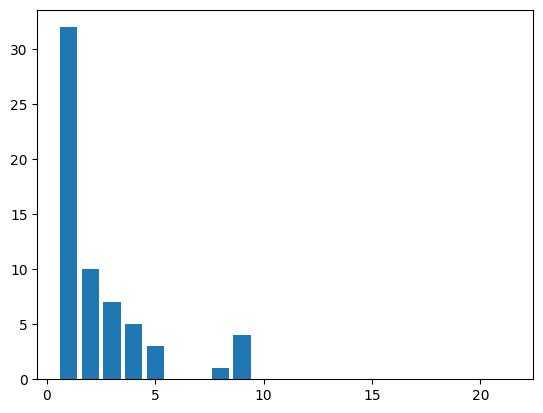

D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



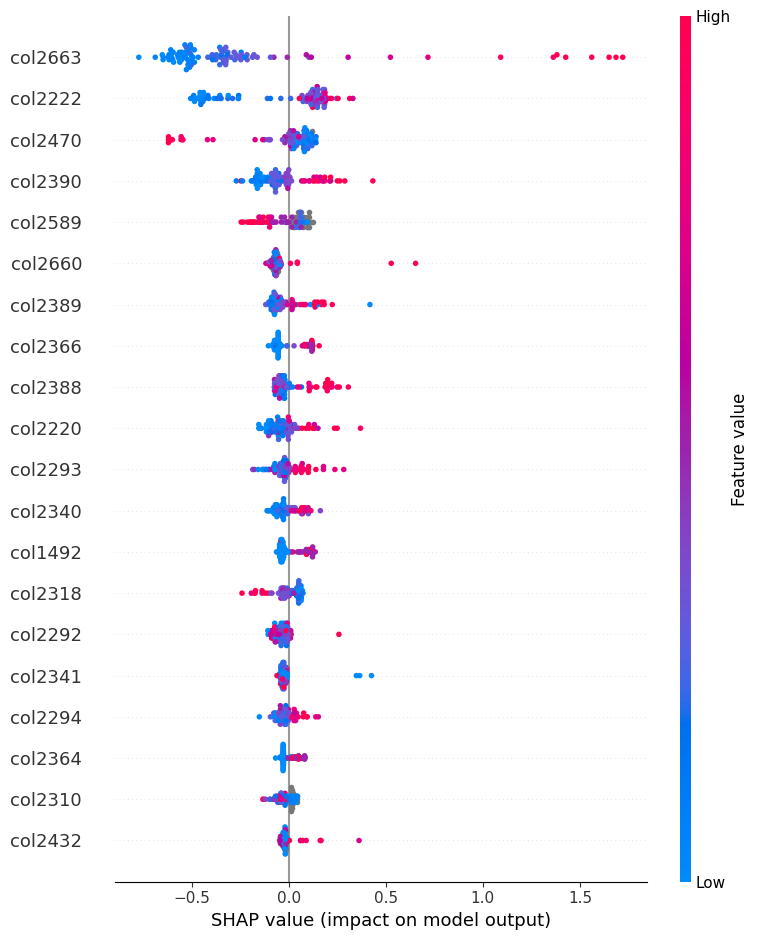

D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



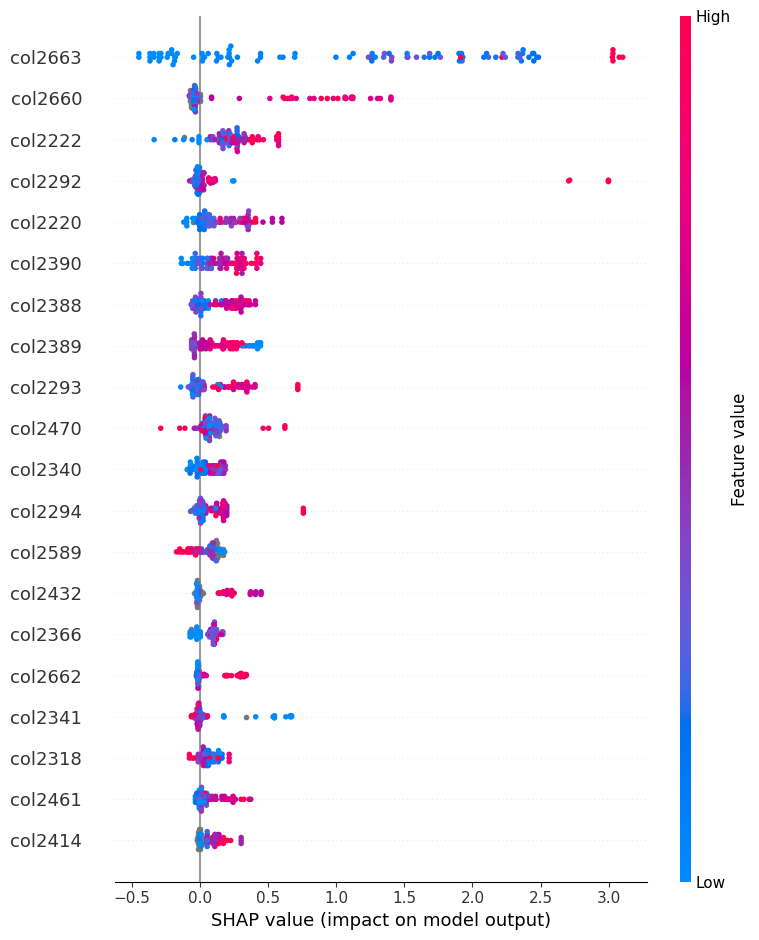

In [51]:
_train_df = train_df.loc[train_df['report_date'].isin(['2022-11-01','2022-10-01','2022-09-01','2022-08-01','2022-07-01'])]
len_ones =_train_df.loc[_train_df['target']==1].shape[0]
zeros = _train_df.loc[_train_df['target']==0].sample(n=len_ones*6, random_state=1)
ones = _train_df.loc[_train_df['target']==1]
_train_df = pd.concat([zeros,ones])

pool_train = Pool(
    _train_df.drop(['target','report_date'], axis=1),
    _train_df['target'],
    cat_features = list(
        _train_df.drop(['target','report_date'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

pool_val = Pool(
    test_df.drop(['target'], axis=1),
    test_df['target'],
    cat_features = list(
        test_df.drop(['target'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

model = fit_catboost(pool_train, pool_val)

predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
print(auc(recall, precision))
print(roc_auc_score(test_df['target'], predictions))

plot_fit_curves(model)
plot_roc_curve(test_df['target'], predictions)
plot_pr_curve(test_df['target'], predictions)
plot_target_segment(test_df['target'], predictions)
plot_shap(model, _train_df)

### Тест на хороших фичах

0.2197243894830346
0.919098343341682


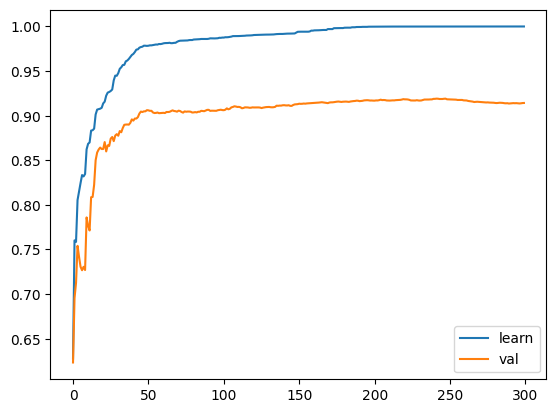

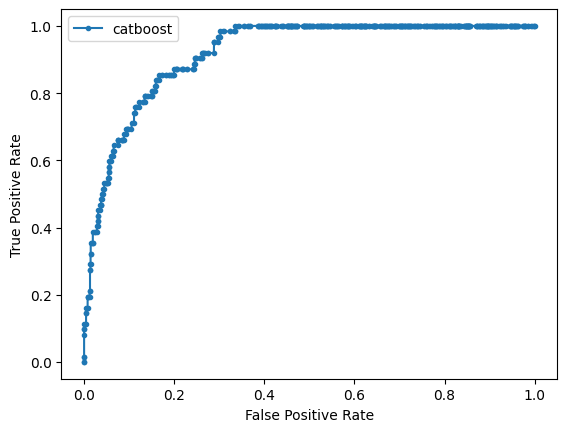

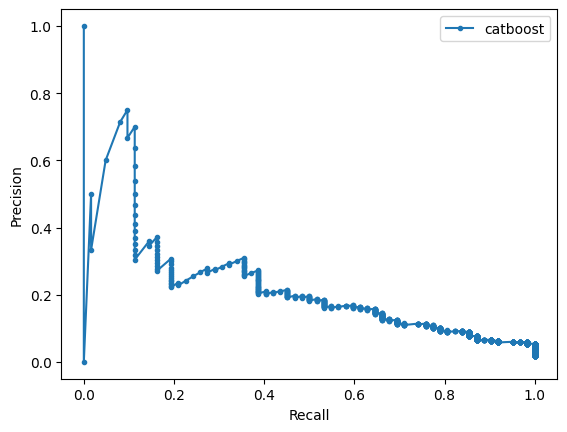

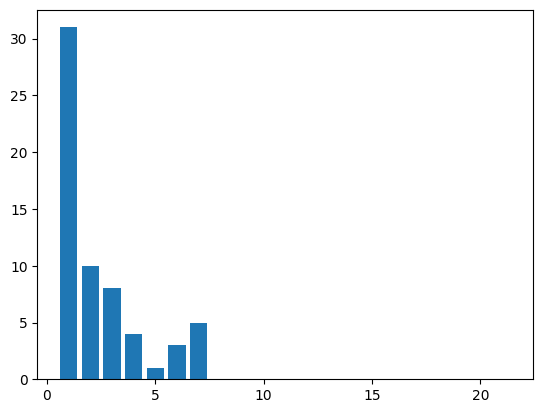

D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



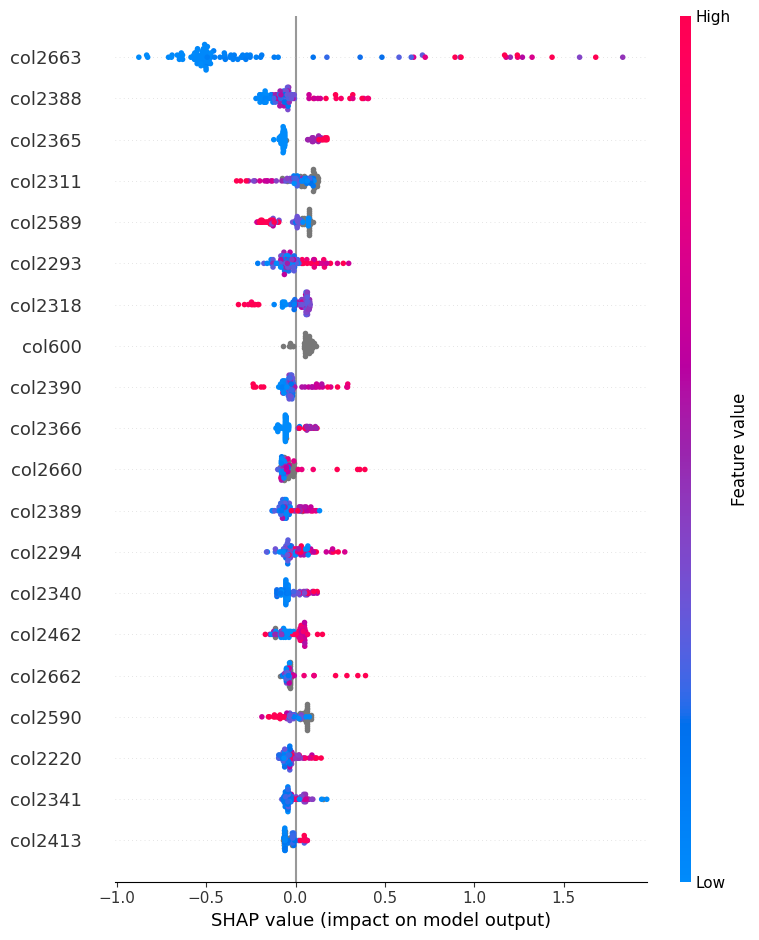

D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



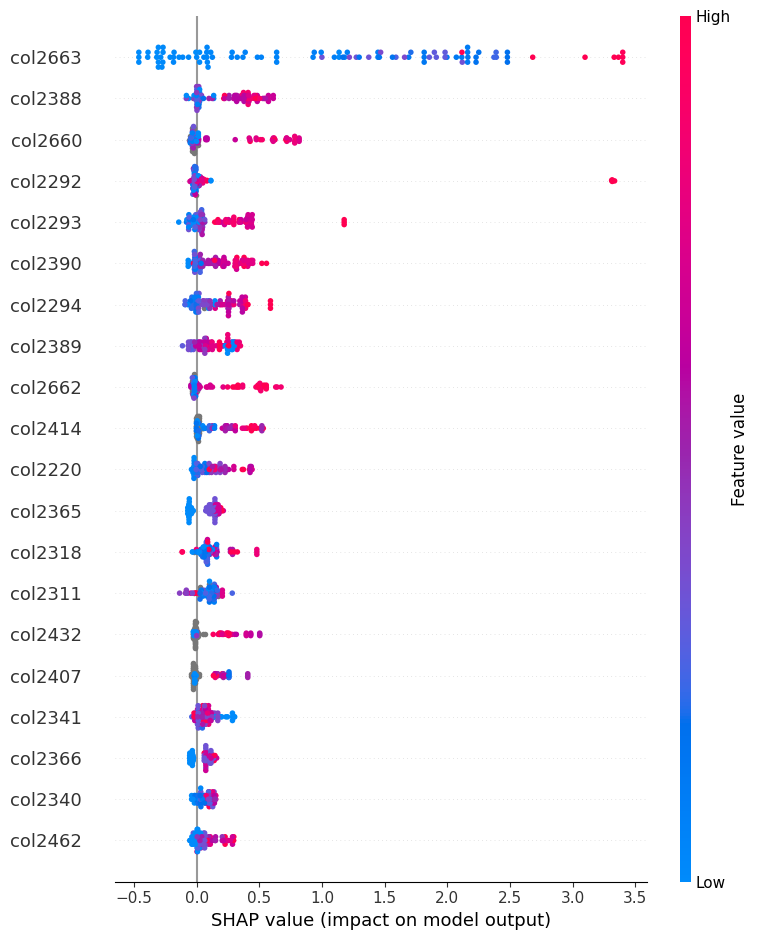

In [52]:
good_features = list(np.load('good_features.npy', allow_pickle=True))
_train_df = train_df[good_features + ['target','report_date']]
_train_df = _train_df.loc[_train_df['report_date'].isin(['2022-11-01','2022-10-01','2022-09-01','2022-08-01','2022-07-01'])]
len_ones =_train_df.loc[_train_df['target']==1].shape[0]
zeros = _train_df.loc[_train_df['target']==0].sample(n=len_ones*6, random_state=1)
ones = _train_df.loc[_train_df['target']==1]
_train_df = pd.concat([zeros,ones])

test_df = test_df[good_features + ['target']]

pool_train = Pool(
    _train_df.drop(['target','report_date'], axis=1),
    _train_df['target'],
    cat_features = list(
        _train_df.drop(['target','report_date'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

pool_val = Pool(
    test_df.drop(['target'], axis=1),
    test_df['target'],
    cat_features = list(
        test_df.drop(['target'], axis=1)
        .select_dtypes(include=['object'])
        .columns
    )
)

model = fit_catboost(pool_train, pool_val)

predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
print(auc(recall, precision))
print(roc_auc_score(test_df['target'], predictions))

plot_fit_curves(model)
plot_roc_curve(test_df['target'], predictions)
plot_pr_curve(test_df['target'], predictions)
plot_target_segment(test_df['target'], predictions)
plot_shap(model, _train_df)

### Сохранение результата

In [54]:
import json

good_features = list(np.load('good_features.npy', allow_pickle=True))
columns_dict = {'columns': good_features}
    
with open("data/columns.json", "w") as outfile:
    json.dump(columns_dict, outfile)

In [55]:
predictions = model.predict_proba(test_df.drop(['target'], axis=1))[:,1]
precision, recall, _ = precision_recall_curve(test_df['target'], predictions)
signature = infer_signature(test_df[good_features], predictions)
print(auc(recall, precision))
print(roc_auc_score(test_df['target'], predictions))
metrics_to_mlflow = {
    'pr_auc':auc(recall, precision),
    'roc_auc':roc_auc_score(test_df['target'], predictions)
}

with mlflow.start_run(run_name=f'catboost_740f'):
    mlflow.log_params(model.get_params())
    mlflow.log_metrics(metrics_to_mlflow)
    mlflow.sklearn.log_model(
        model,
        signature=signature,
        registered_model_name=f'catboost_740f',
        artifact_path=''
    )
    mlflow.set_tags({'model': 'catboost'})
    mlflow.log_artifacts('data')
    print(f'Model saved in run {mlflow.active_run().info.run_uuid}')
mlflow.end_run()

D:\ML_projects\SAMOLET_TARGET_HACK\venv\Lib\site-packages\mlflow\models\signature.py:214: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



0.2197243894830346
0.919098343341682


2023/09/10 09:42:40 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://mlflow/1/f8b8c0b9113e48a996d0fd3a19632095/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Successfully registered model 'catboost_740f'.
2023/09/10 09:42:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: catboost_740f, version 1
Created version '1' of model 'catboost_740f'.


Model saved in run f8b8c0b9113e48a996d0fd3a19632095
